In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from collections import OrderedDict
from tqdm import tqdm
import copy

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
def load_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            if not line.strip():
                continue
            parts = line.strip().replace(';', ',').split(',')
            if len(parts) < 6:
                continue
                
            cleaned_parts = []
            for part in parts[:6]:  
                part = part.strip()
                if not part:  
                    cleaned_parts.append(np.nan)
                else:
                    cleaned_parts.append(part)
            
            data.append(cleaned_parts)
    
    columns = ['user_id', 'activity', 'timestamp', 'x_accel', 'y_accel', 'z_accel']
    df = pd.DataFrame(data, columns=columns)
    
    df['user_id'] = pd.to_numeric(df['user_id'], errors='coerce')
    
    df = df.drop('timestamp', axis=1)
    
    for col in ['x_accel', 'y_accel', 'z_accel']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    df.dropna(inplace=True)
    
    df['user_id'] = df['user_id'].astype(int)
    
    return df

In [3]:
file_path = "/kaggle/input/human-activity/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt"
data = load_data(file_path)

print(f"Dataset shape: {data.shape}")
print("\nActivity distribution:")
print(data['activity'].value_counts())

Dataset shape: (1098203, 5)

Activity distribution:
activity
Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: count, dtype: int64


In [4]:
## Feature Engineering
def create_sequences(data, window_size=100, step_size=50):
    sequences = []
    labels = []
    users = []
    
    for user_id in data['user_id'].unique():
        user_data = data[data['user_id'] == user_id]
        
        for activity in user_data['activity'].unique():
            activity_data = user_data[user_data['activity'] == activity]
            accel_data = activity_data[['x_accel', 'y_accel', 'z_accel']].values
            
            for i in range(0, len(accel_data) - window_size, step_size):
                sequence = accel_data[i:i + window_size]
                sequences.append(sequence)
                labels.append(activity)
                users.append(user_id)
    
    return np.array(sequences), np.array(labels), np.array(users)

In [5]:
# Create sequences
window_size = 100  
step_size = 50    
X, y, users = create_sequences(data, window_size, step_size)

print(f"\nTotal sequences: {len(X)}")
print(f"Sequence shape: {X[0].shape}")

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

normalized_X = np.zeros_like(X)
for user_id in np.unique(users):
    user_mask = (users == user_id)
    user_data = X[user_mask]
    original_shape = user_data.shape
    flattened = user_data.reshape(-1, user_data.shape[-1])
    scaler = StandardScaler()
    scaled = scaler.fit_transform(flattened)
    normalized_X[user_mask] = scaled.reshape(original_shape)

X = normalized_X

unique_users = np.unique(users)
train_users, test_users = train_test_split(unique_users, test_size=0.2, random_state=42)

train_mask = np.isin(users, train_users)
test_mask = np.isin(users, test_users)

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y_encoded[train_mask], y_encoded[test_mask]
users_train, users_test = users[train_mask], users[test_mask]

print("\nTrain/test split:")
print(f"Train samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")


Total sequences: 21689
Sequence shape: (100, 3)

Train/test split:
Train samples: 16423
Test samples: 5266


In [6]:
## Federated Learning Setup
class FederatedClient:
    def __init__(self, client_id, X, y, batch_size=32):
        self.client_id = client_id
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.dataset = TensorDataset(torch.FloatTensor(X), torch.LongTensor(y))
        self.loader = DataLoader(self.dataset, batch_size=batch_size, shuffle=True)
        
    def train(self, model, criterion, optimizer, epochs=1):
        model.train()
        model = model.to(device)     
        epoch_loss = 0.0
        correct = 0
        total = 0
        
        for _ in range(epochs):
            for inputs, labels in self.loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        avg_loss = epoch_loss / len(self.loader)
        
        return avg_loss, accuracy, model.state_dict()

In [7]:
def create_clients(X, y, users, num_clients=10):
    unique_users = np.unique(users)
    np.random.shuffle(unique_users)
    clients_users = np.array_split(unique_users, num_clients)
    
    clients = []
    for i, client_users in enumerate(clients_users):
        client_mask = np.isin(users, client_users)
        client_X = X[client_mask]
        client_y = y[client_mask]
        if len(client_X) > window_size:
            clients.append(FederatedClient(i, client_X, client_y))
    
    print(f"\nCreated {len(clients)} federated clients")
    return clients

In [8]:
# Create federated clients
clients = create_clients(X_train, y_train, users_train, num_clients=10)


Created 10 federated clients


In [9]:
## KAN Model Implementation
class KANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64):
        super(KANLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.phi = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.psi = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        phi_out = self.phi(x)
        psi_out = self.psi(phi_out)
        return psi_out

class KANModel(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(KANModel, self).__init__()
        self.input_shape = input_shape  
        self.num_classes = num_classes
        self.temporal_kan = KANLayer(input_shape[1], 64)
        self.lstm = nn.LSTM(64, 128, batch_first=True, bidirectional=True)
        
        self.attention = nn.Sequential(
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
            nn.Softmax(dim=1)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        x = x.view(-1, self.input_shape[1])  
        x = self.temporal_kan(x)
        x = x.view(batch_size, seq_len, -1) 
        lstm_out, _ = self.lstm(x) 
        
        attention_weights = self.attention(lstm_out)
        context = torch.sum(attention_weights * lstm_out, dim=1)
        out = self.classifier(context)
        
        return out

In [10]:
# Initialize global model
input_shape = (window_size, 3)  
num_classes = len(label_encoder.classes_)
global_model = KANModel(input_shape, num_classes).to(device)

print("\nModel architecture:")
print(global_model)


Model architecture:
KANModel(
  (temporal_kan): KANLayer(
    (phi): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
    )
    (psi): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (lstm): LSTM(64, 128, batch_first=True, bidirectional=True)
  (attention): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Softmax(dim=1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=6, bias=True)
  )
)


In [11]:
## Federated Training
def federated_averaging(global_model, client_models):
    global_dict = global_model.state_dict()
    averaged_params = OrderedDict()
    for key in global_dict.keys():
        averaged_params[key] = torch.zeros_like(global_dict[key])
    
    for client_state in client_models:
        for key in client_state:
            averaged_params[key] += client_state[key]
    
    for key in averaged_params:
        averaged_params[key] = averaged_params[key] / len(client_models)
    
    global_model.load_state_dict(averaged_params)
    return global_model

In [12]:
def evaluate(model, X, y, batch_size=64):
    model.eval()
    model = model.to(device) 
    dataset = TensorDataset(torch.FloatTensor(X), torch.LongTensor(y))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
    
    accuracy = 100 * correct / total
    avg_loss = total_loss / len(loader)
    
    return avg_loss, accuracy, np.array(all_preds), np.array(all_labels), np.array(all_probs)

In [13]:
def train_federated(clients, global_model, num_rounds=20, client_fraction=0.5, client_epochs=1):
    criterion = nn.CrossEntropyLoss()
    optimizer_fn = lambda model: optim.Adam(model.parameters(), lr=0.001)
    global_train_loss = []
    global_train_acc = []
    global_test_loss = []
    global_test_acc = []
    
    # Metrics storage
    metrics = {
        'precision': {cls: [] for cls in label_encoder.classes_},
        'recall': {cls: [] for cls in label_encoder.classes_},
        'f1': {cls: [] for cls in label_encoder.classes_},
        'macro_precision': [],
        'macro_recall': [],
        'macro_f1': []
    }
    
    for round_num in range(num_rounds):
        print(f"\nRound {round_num + 1}/{num_rounds}")
        num_selected = max(1, int(len(clients) * client_fraction))
        selected_clients = np.random.choice(clients, size=num_selected, replace=False)
        client_models = []
        client_losses = []
        client_accs = []
        
        for client in tqdm(selected_clients, desc="Client Training"):
            client_model = copy.deepcopy(global_model)
            client_optimizer = optimizer_fn(client_model)
            loss, acc, state_dict = client.train(
                client_model, criterion, client_optimizer, epochs=client_epochs
            )
            
            client_models.append(state_dict)
            client_losses.append(loss)
            client_accs.append(acc)
        
        global_model = federated_averaging(global_model, client_models)
        train_loss, train_acc, _, _, _ = evaluate(global_model, X_train, y_train)
        global_train_loss.append(train_loss)
        global_train_acc.append(train_acc)
        test_loss, test_acc, test_preds, test_labels, test_probs = evaluate(global_model, X_test, y_test)
        global_test_loss.append(test_loss)
        global_test_acc.append(test_acc)
        
        # Calculate and store detailed metrics
        class_report = classification_report(
            test_labels, test_preds, 
            target_names=label_encoder.classes_, 
            output_dict=True
        )
        
        for cls in label_encoder.classes_:
            metrics['precision'][cls].append(class_report[cls]['precision'])
            metrics['recall'][cls].append(class_report[cls]['recall'])
            metrics['f1'][cls].append(class_report[cls]['f1-score'])
        
        metrics['macro_precision'].append(class_report['macro avg']['precision'])
        metrics['macro_recall'].append(class_report['macro avg']['recall'])
        metrics['macro_f1'].append(class_report['macro avg']['f1-score'])
        
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")
        print(f"Precision: {metrics['macro_precision'][-1]:.4f}")
        print(f"Recall: {metrics['macro_recall'][-1]:.4f}")
        print(f"F1 Score: {metrics['macro_f1'][-1]:.4f}")
    
    return (
        global_model, 
        global_train_loss, global_train_acc, 
        global_test_loss, global_test_acc,
        metrics
    )

In [15]:
# Run federated training
num_rounds = 30
client_fraction = 0.7  
client_epochs = 5     
(
    trained_model, 
    train_losses, train_accs, 
    test_losses, test_accs,
    metrics
) = train_federated(
    clients, global_model, 
    num_rounds=num_rounds,
    client_fraction=client_fraction,
    client_epochs=client_epochs
)


Round 1/30


Client Training: 100%|██████████| 7/7 [00:09<00:00,  1.41s/it]


Train Loss: 0.9967 | Train Acc: 77.32%
Test Loss: 1.0966 | Test Acc: 72.90%
Precision: 0.6178
Recall: 0.6558
F1 Score: 0.6092

Round 2/30


Client Training: 100%|██████████| 7/7 [00:09<00:00,  1.40s/it]


Train Loss: 0.7746 | Train Acc: 81.29%
Test Loss: 0.9341 | Test Acc: 81.88%
Precision: 0.7662
Recall: 0.7503
F1 Score: 0.7519

Round 3/30


Client Training: 100%|██████████| 7/7 [00:09<00:00,  1.38s/it]


Train Loss: 0.7566 | Train Acc: 84.10%
Test Loss: 0.7388 | Test Acc: 82.80%
Precision: 0.8135
Recall: 0.8066
F1 Score: 0.7991

Round 4/30


Client Training: 100%|██████████| 7/7 [00:09<00:00,  1.39s/it]


Train Loss: 0.5392 | Train Acc: 88.38%
Test Loss: 0.7768 | Test Acc: 85.11%
Precision: 0.8399
Recall: 0.8202
F1 Score: 0.8204

Round 5/30


Client Training: 100%|██████████| 7/7 [00:09<00:00,  1.35s/it]


Train Loss: 0.5725 | Train Acc: 88.21%
Test Loss: 0.7065 | Test Acc: 84.12%
Precision: 0.8274
Recall: 0.8193
F1 Score: 0.8154

Round 6/30


Client Training: 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]


Train Loss: 0.4326 | Train Acc: 90.67%
Test Loss: 0.6119 | Test Acc: 86.44%
Precision: 0.8386
Recall: 0.8385
F1 Score: 0.8332

Round 7/30


Client Training: 100%|██████████| 7/7 [00:10<00:00,  1.45s/it]


Train Loss: 0.5008 | Train Acc: 89.62%
Test Loss: 0.6383 | Test Acc: 86.19%
Precision: 0.8286
Recall: 0.8304
F1 Score: 0.8261

Round 8/30


Client Training: 100%|██████████| 7/7 [00:09<00:00,  1.41s/it]


Train Loss: 0.4414 | Train Acc: 90.64%
Test Loss: 0.4852 | Test Acc: 89.78%
Precision: 0.8674
Recall: 0.8557
F1 Score: 0.8594

Round 9/30


Client Training: 100%|██████████| 7/7 [00:09<00:00,  1.42s/it]


Train Loss: 0.4319 | Train Acc: 91.32%
Test Loss: 0.5640 | Test Acc: 89.40%
Precision: 0.8720
Recall: 0.8610
F1 Score: 0.8597

Round 10/30


Client Training: 100%|██████████| 7/7 [00:09<00:00,  1.40s/it]


Train Loss: 0.3682 | Train Acc: 92.97%
Test Loss: 0.7308 | Test Acc: 87.37%
Precision: 0.8680
Recall: 0.8297
F1 Score: 0.8408

Round 11/30


Client Training: 100%|██████████| 7/7 [00:10<00:00,  1.46s/it]


Train Loss: 0.3766 | Train Acc: 92.08%
Test Loss: 0.5397 | Test Acc: 89.82%
Precision: 0.8806
Recall: 0.8520
F1 Score: 0.8618

Round 12/30


Client Training: 100%|██████████| 7/7 [00:10<00:00,  1.43s/it]


Train Loss: 0.2938 | Train Acc: 93.66%
Test Loss: 0.5759 | Test Acc: 89.44%
Precision: 0.8733
Recall: 0.8519
F1 Score: 0.8577

Round 13/30


Client Training: 100%|██████████| 7/7 [00:09<00:00,  1.39s/it]


Train Loss: 0.4097 | Train Acc: 92.53%
Test Loss: 0.6757 | Test Acc: 89.16%
Precision: 0.8759
Recall: 0.8578
F1 Score: 0.8615

Round 14/30


Client Training: 100%|██████████| 7/7 [00:09<00:00,  1.36s/it]


Train Loss: 0.4278 | Train Acc: 92.86%
Test Loss: 0.5879 | Test Acc: 90.28%
Precision: 0.8820
Recall: 0.8683
F1 Score: 0.8712

Round 15/30


Client Training: 100%|██████████| 7/7 [00:09<00:00,  1.36s/it]


Train Loss: 0.3156 | Train Acc: 93.75%
Test Loss: 0.7627 | Test Acc: 88.85%
Precision: 0.8872
Recall: 0.8523
F1 Score: 0.8620

Round 16/30


Client Training: 100%|██████████| 7/7 [00:10<00:00,  1.45s/it]


Train Loss: 0.2863 | Train Acc: 94.53%
Test Loss: 0.6564 | Test Acc: 89.37%
Precision: 0.8781
Recall: 0.8662
F1 Score: 0.8673

Round 17/30


Client Training: 100%|██████████| 7/7 [00:09<00:00,  1.40s/it]


Train Loss: 0.3815 | Train Acc: 93.89%
Test Loss: 0.7585 | Test Acc: 89.37%
Precision: 0.8773
Recall: 0.8637
F1 Score: 0.8658

Round 18/30


Client Training: 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]


Train Loss: 0.3085 | Train Acc: 93.61%
Test Loss: 0.5853 | Test Acc: 90.14%
Precision: 0.8808
Recall: 0.8642
F1 Score: 0.8682

Round 19/30


Client Training: 100%|██████████| 7/7 [00:10<00:00,  1.44s/it]


Train Loss: 0.3515 | Train Acc: 93.86%
Test Loss: 0.5971 | Test Acc: 90.68%
Precision: 0.8759
Recall: 0.8777
F1 Score: 0.8737

Round 20/30


Client Training: 100%|██████████| 7/7 [00:09<00:00,  1.41s/it]


Train Loss: 0.2373 | Train Acc: 94.84%
Test Loss: 0.4866 | Test Acc: 91.28%
Precision: 0.8909
Recall: 0.8816
F1 Score: 0.8830

Round 21/30


Client Training: 100%|██████████| 7/7 [00:10<00:00,  1.43s/it]


Train Loss: 0.2750 | Train Acc: 94.43%
Test Loss: 0.5506 | Test Acc: 90.64%
Precision: 0.8803
Recall: 0.8744
F1 Score: 0.8746

Round 22/30


Client Training: 100%|██████████| 7/7 [00:09<00:00,  1.32s/it]


Train Loss: 0.2315 | Train Acc: 95.35%
Test Loss: 0.7918 | Test Acc: 88.82%
Precision: 0.8866
Recall: 0.8568
F1 Score: 0.8659

Round 23/30


Client Training: 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]


Train Loss: 0.2810 | Train Acc: 95.07%
Test Loss: 0.8076 | Test Acc: 88.97%
Precision: 0.8922
Recall: 0.8593
F1 Score: 0.8707

Round 24/30


Client Training: 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]


Train Loss: 0.2699 | Train Acc: 95.60%
Test Loss: 0.8182 | Test Acc: 89.97%
Precision: 0.8930
Recall: 0.8672
F1 Score: 0.8758

Round 25/30


Client Training: 100%|██████████| 7/7 [00:09<00:00,  1.38s/it]


Train Loss: 0.2415 | Train Acc: 95.62%
Test Loss: 0.6351 | Test Acc: 90.75%
Precision: 0.8826
Recall: 0.8756
F1 Score: 0.8766

Round 26/30


Client Training: 100%|██████████| 7/7 [00:09<00:00,  1.41s/it]


Train Loss: 0.2119 | Train Acc: 95.76%
Test Loss: 0.5467 | Test Acc: 91.32%
Precision: 0.8839
Recall: 0.8842
F1 Score: 0.8814

Round 27/30


Client Training: 100%|██████████| 7/7 [00:10<00:00,  1.44s/it]


Train Loss: 0.2054 | Train Acc: 96.20%
Test Loss: 0.6843 | Test Acc: 90.68%
Precision: 0.9004
Recall: 0.8661
F1 Score: 0.8789

Round 28/30


Client Training: 100%|██████████| 7/7 [00:10<00:00,  1.44s/it]


Train Loss: 0.2471 | Train Acc: 95.56%
Test Loss: 0.6682 | Test Acc: 90.56%
Precision: 0.8860
Recall: 0.8782
F1 Score: 0.8792

Round 29/30


Client Training: 100%|██████████| 7/7 [00:09<00:00,  1.38s/it]


Train Loss: 0.2478 | Train Acc: 95.71%
Test Loss: 0.8213 | Test Acc: 89.57%
Precision: 0.8925
Recall: 0.8629
F1 Score: 0.8732

Round 30/30


Client Training: 100%|██████████| 7/7 [00:09<00:00,  1.34s/it]


Train Loss: 0.1978 | Train Acc: 96.43%
Test Loss: 0.7238 | Test Acc: 90.35%
Precision: 0.8846
Recall: 0.8836
F1 Score: 0.8813


In [16]:
## Evaluation and Visualization
def plot_metrics(train_losses, train_accs, test_losses, test_accs):
    plt.figure(figsize=(12, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Round')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss')
    plt.legend()
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.xlabel('Round')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Testing Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_detailed_metrics(metrics):
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))
    
    axes[0].plot(metrics['macro_precision'], label='Macro Precision')
    axes[0].set_title('Precision Over Rounds')
    axes[0].set_xlabel('Round')
    axes[0].set_ylabel('Precision')
    
    axes[1].plot(metrics['macro_recall'], label='Macro Recall')
    axes[1].set_title('Recall Over Rounds')
    axes[1].set_xlabel('Round')
    axes[1].set_ylabel('Recall')
    
    axes[2].plot(metrics['macro_f1'], label='Macro F1')
    axes[2].set_title('F1 Score Over Rounds')
    axes[2].set_xlabel('Round')
    axes[2].set_ylabel('F1 Score')
    
    plt.tight_layout()
    plt.show()
    
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))
    
    for cls in metrics['precision'].keys():
        axes[0].plot(metrics['precision'][cls], label=cls)
        axes[1].plot(metrics['recall'][cls], label=cls)
        axes[2].plot(metrics['f1'][cls], label=cls)
    
    axes[0].set_title('Per-Class Precision Over Rounds')
    axes[0].set_xlabel('Round')
    axes[0].set_ylabel('Precision')
    axes[0].legend()
    
    axes[1].set_title('Per-Class Recall Over Rounds')
    axes[1].set_xlabel('Round')
    axes[1].set_ylabel('Recall')
    axes[1].legend()
    
    axes[2].set_title('Per-Class F1 Score Over Rounds')
    axes[2].set_xlabel('Round')
    axes[2].set_ylabel('F1 Score')
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, X, y):
    _, _, preds, labels, _ = evaluate(model, X, y)
    
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def plot_roc_curve(model, X, y):
    y_bin = label_binarize(y, classes=np.arange(len(label_encoder.classes_)))
    n_classes = y_bin.shape[1]
    
    _, _, _, _, probs = evaluate(model, X, y)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of {0} (area = {1:0.2f})'
                 ''.format(label_encoder.classes_[i], roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_true_vs_predicted(model, X, y, num_samples=100):
    _, _, preds, labels, _ = evaluate(model, X, y)
    
    idx = np.random.choice(len(labels), size=min(num_samples, len(labels)), replace=False)
    sample_preds = preds[idx]
    sample_labels = labels[idx]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(idx)), sample_labels, label='True', alpha=0.7)
    plt.scatter(range(len(idx)), sample_preds, label='Predicted', alpha=0.7)
    plt.xlabel('Sample Index')
    plt.ylabel('Class')
    plt.yticks(range(len(label_encoder.classes_)), label_encoder.classes_)
    plt.title('True vs Predicted Labels (Sample)')
    plt.legend()
    plt.show()

def plot_activity_curves(model, X, y, activity_index=0):
    activity_name = label_encoder.classes_[activity_index]
    activity_mask = (y == activity_index)
    X_activity = X[activity_mask]
    y_activity = y[activity_mask]
    samples = X_activity[:5] 
    
    plt.figure(figsize=(12, 6))
    for i, sample in enumerate(samples):
        plt.subplot(2, 3, i+1)
        plt.plot(sample[:, 0], label='X-axis')
        plt.plot(sample[:, 1], label='Y-axis')
        plt.plot(sample[:, 2], label='Z-axis')
        plt.title(f'{activity_name} Sample {i+1}')
        plt.xlabel('Time Step')
        plt.ylabel('Acceleration')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

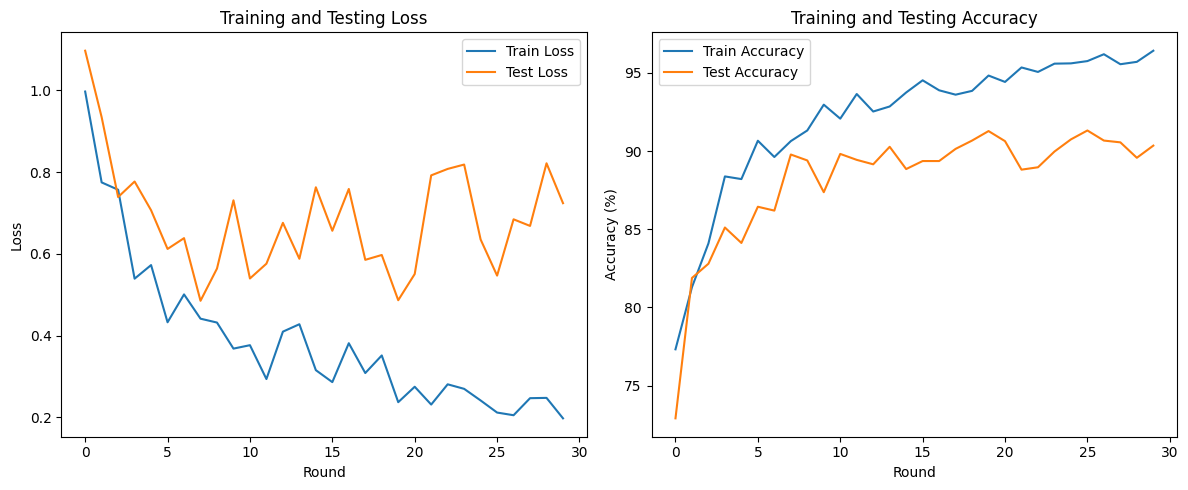

In [17]:
# Plot metrics
plot_metrics(train_losses, train_accs, test_losses, test_accs)

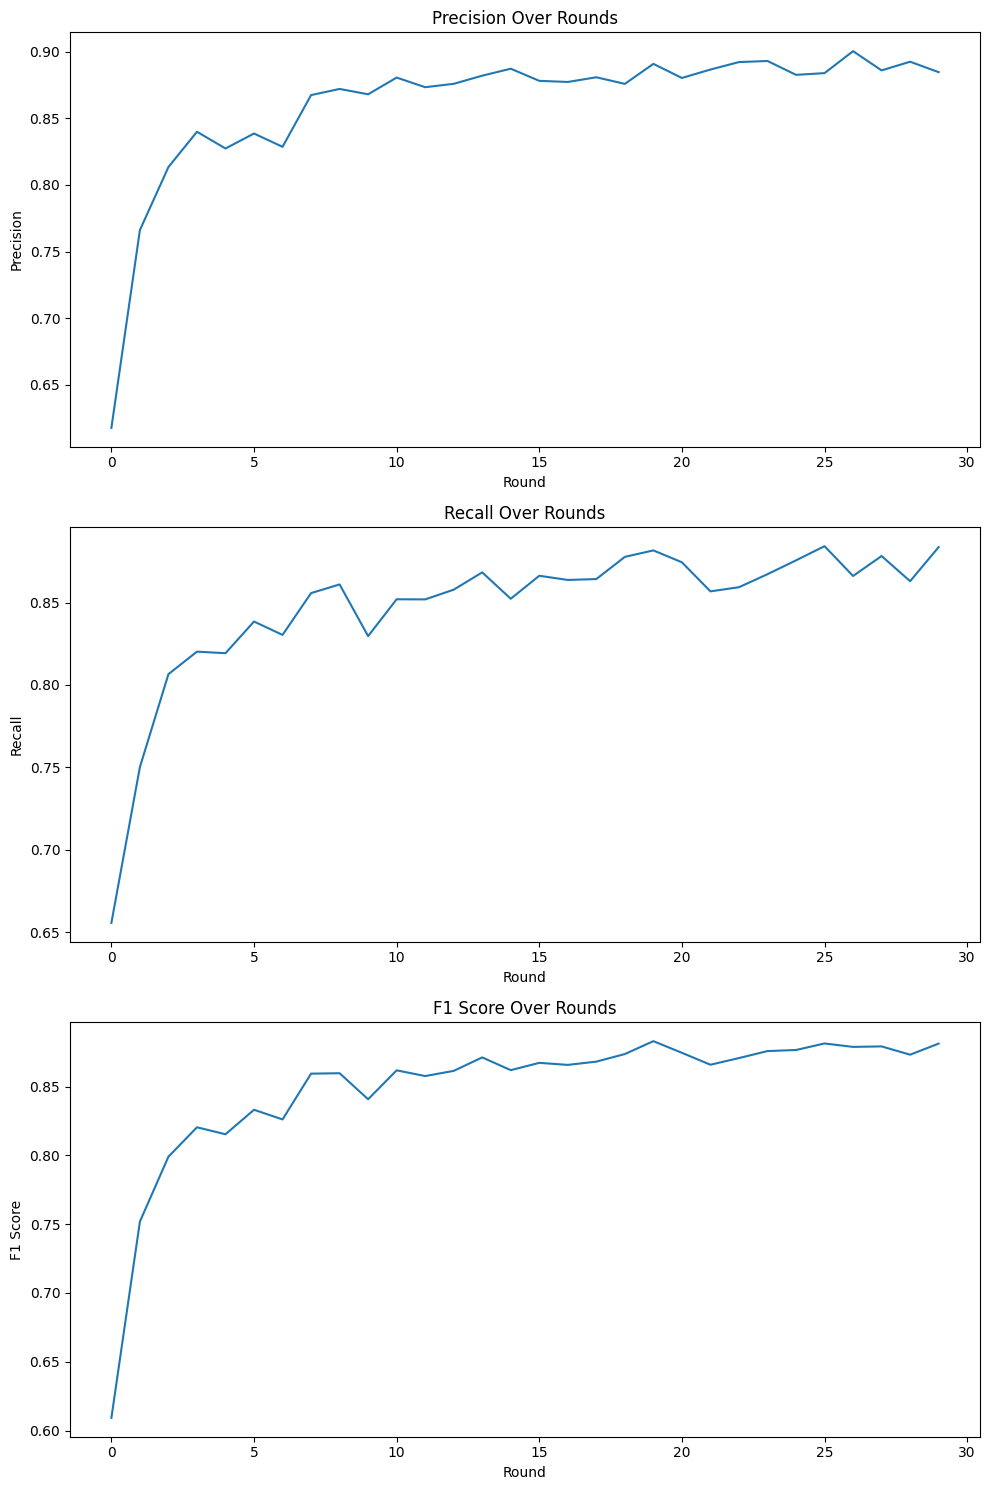

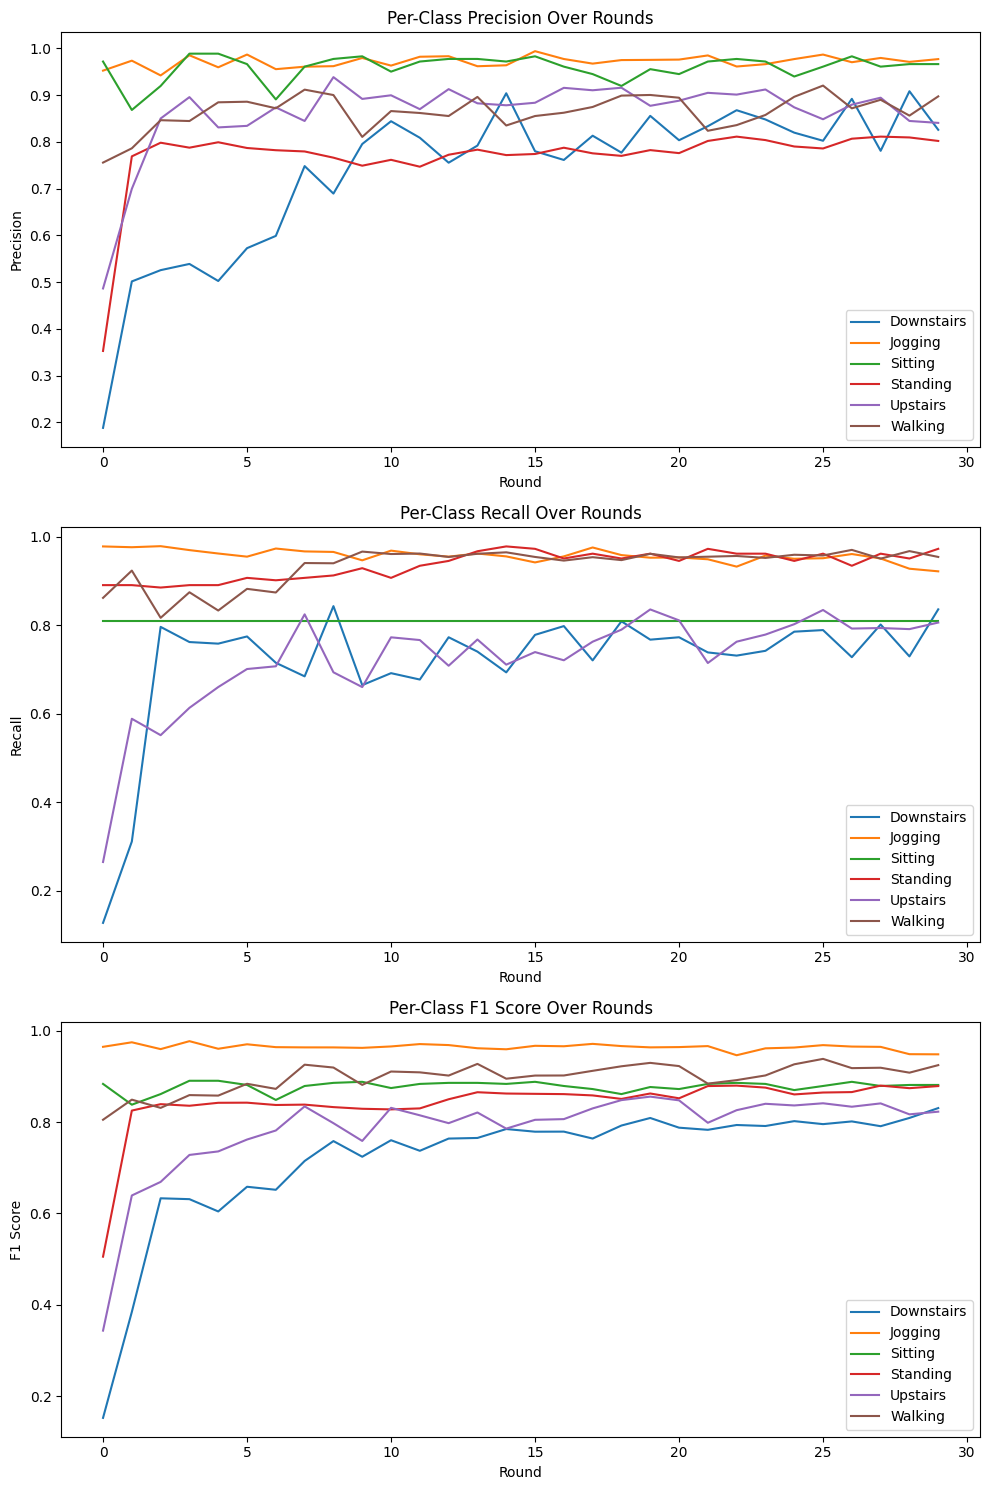

In [18]:
# Plot detailed metrics
plot_detailed_metrics(metrics)

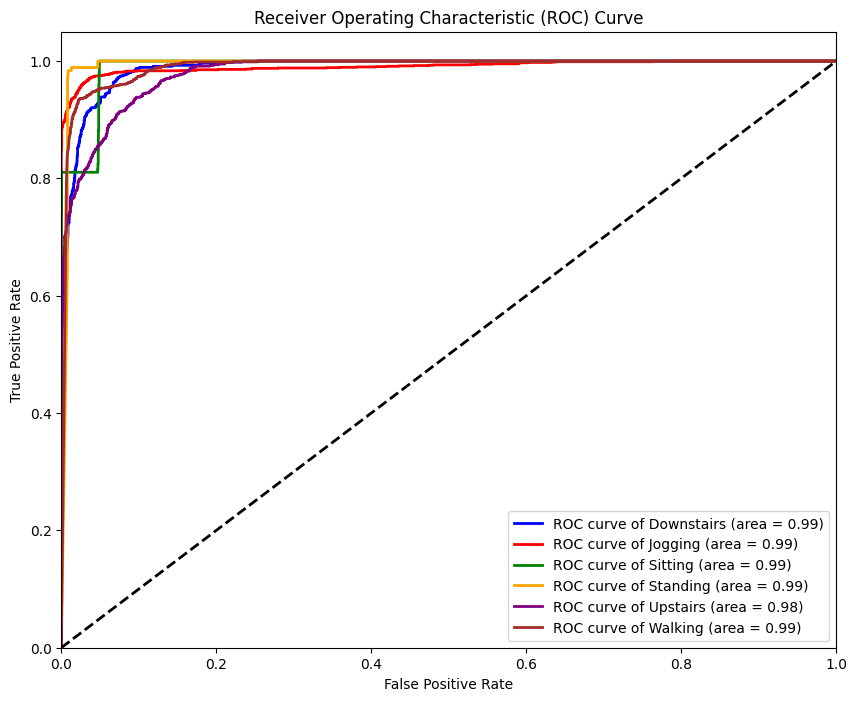

In [19]:
# Plot ROC curve
plot_roc_curve(trained_model, X_test, y_test)

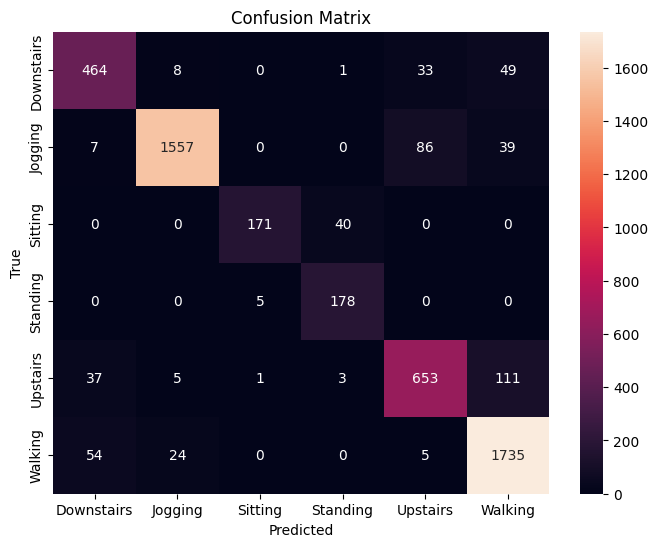

In [20]:
# Plot confusion matrix
plot_confusion_matrix(trained_model, X_test, y_test)

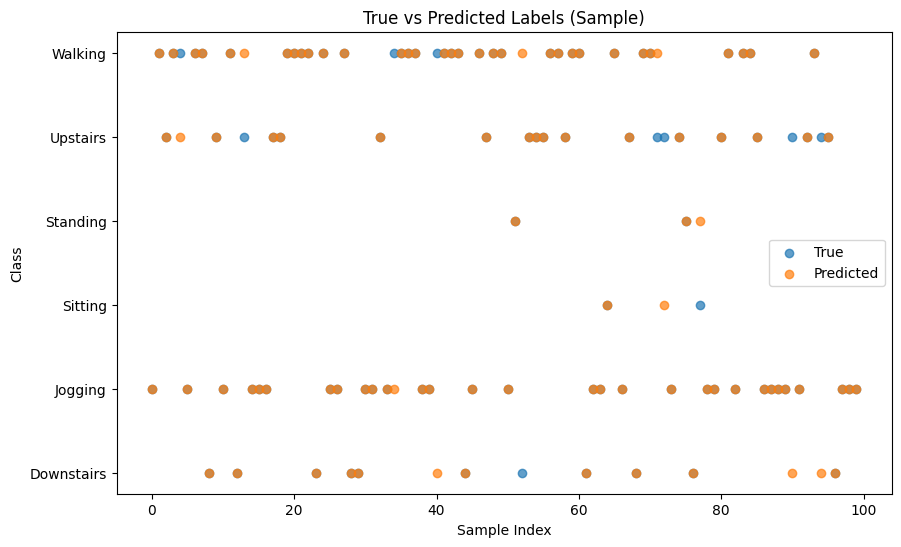

In [21]:
# Plot true vs predicted
plot_true_vs_predicted(trained_model, X_test, y_test)


Activity curves for: Downstairs


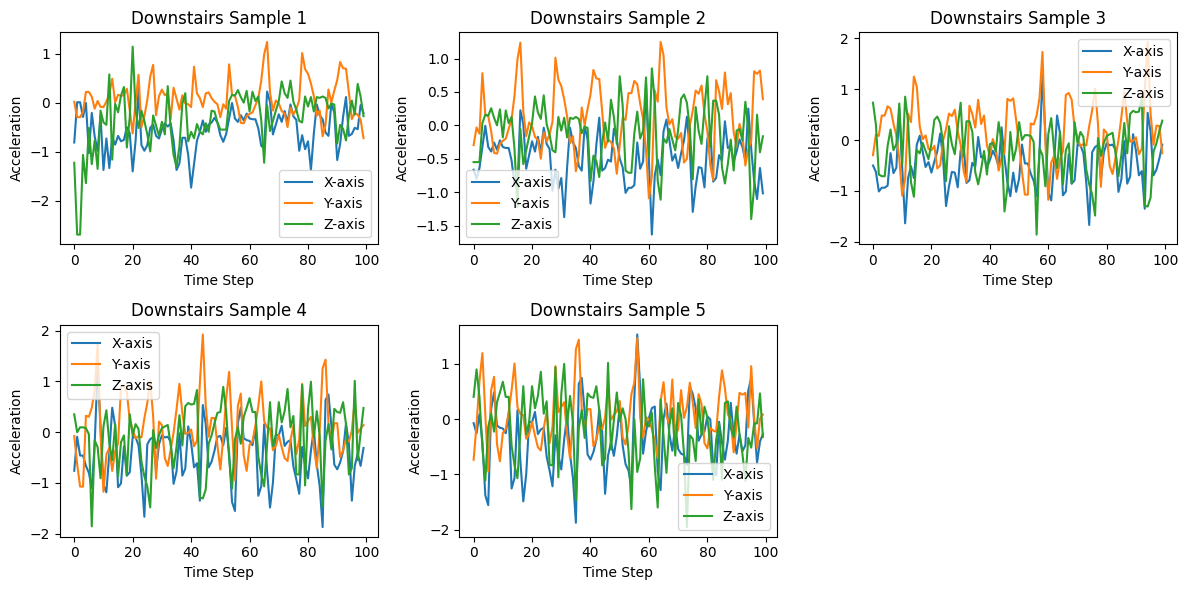


Activity curves for: Jogging


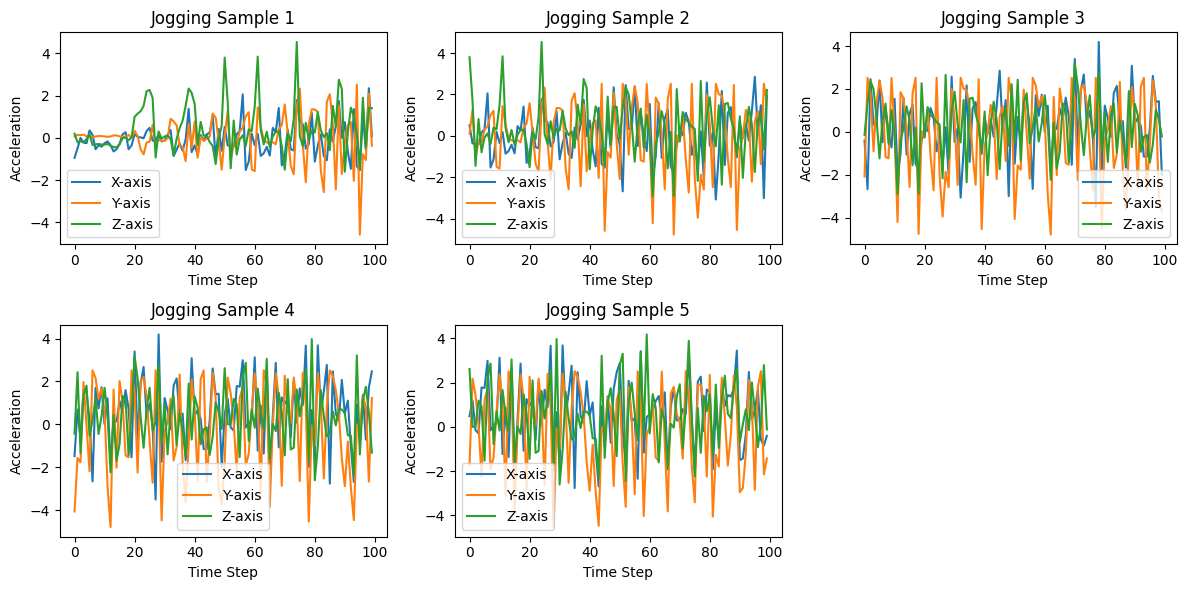


Activity curves for: Sitting


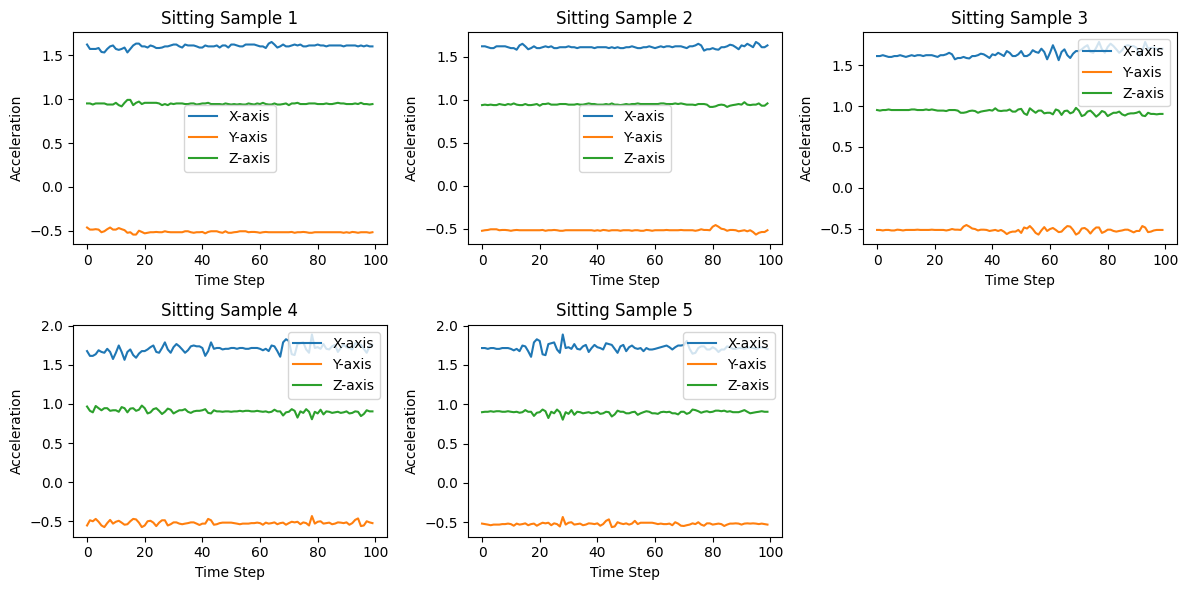


Activity curves for: Standing


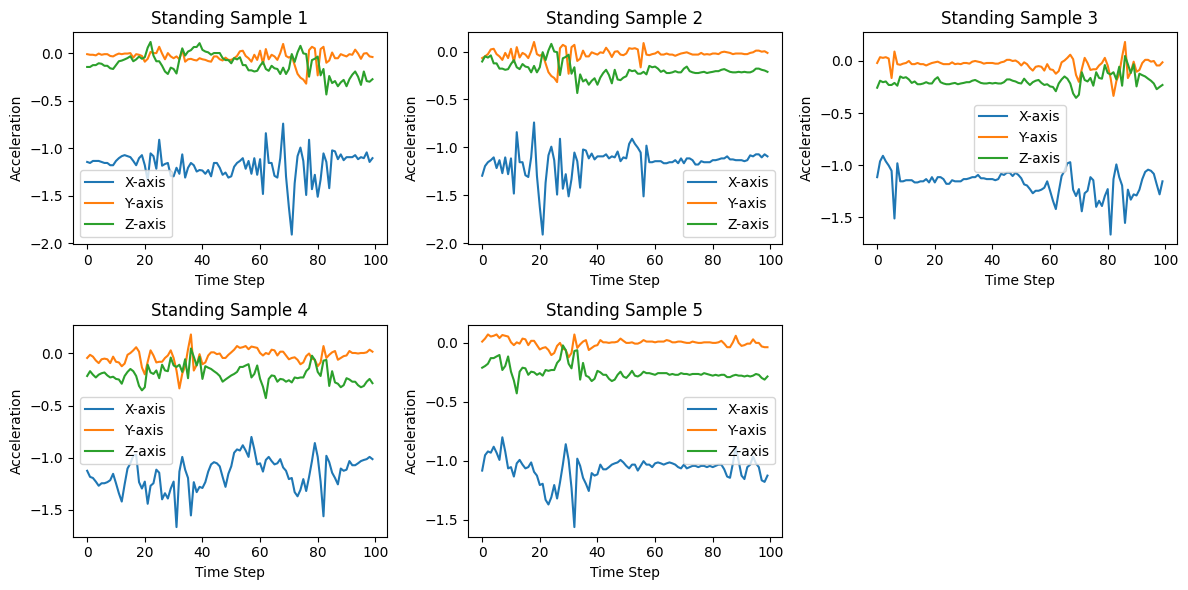


Activity curves for: Upstairs


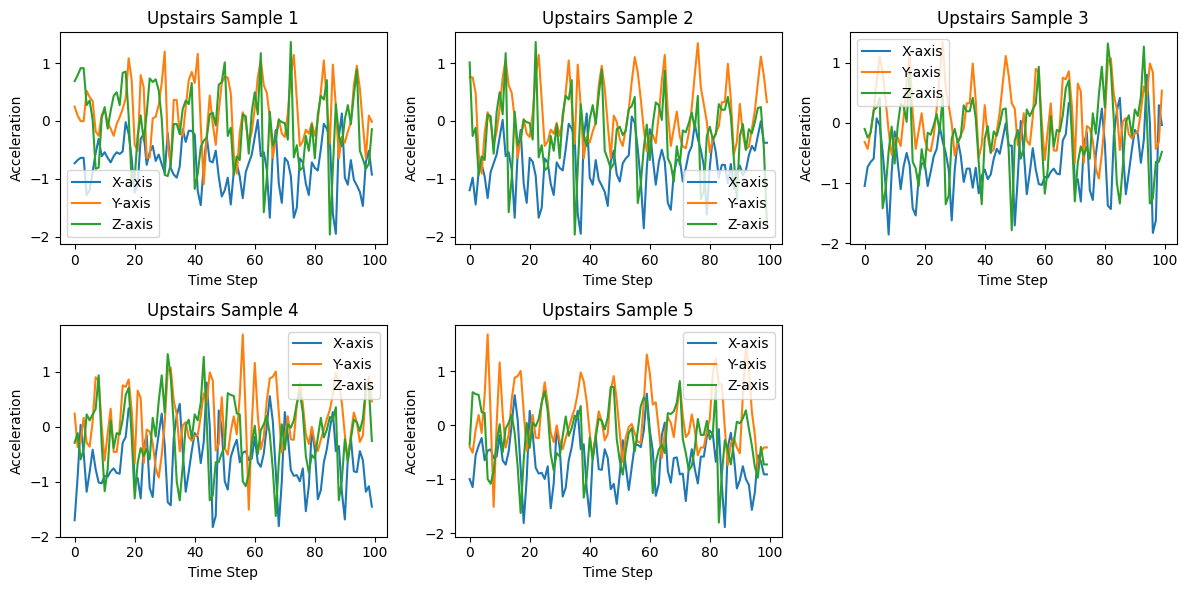


Activity curves for: Walking


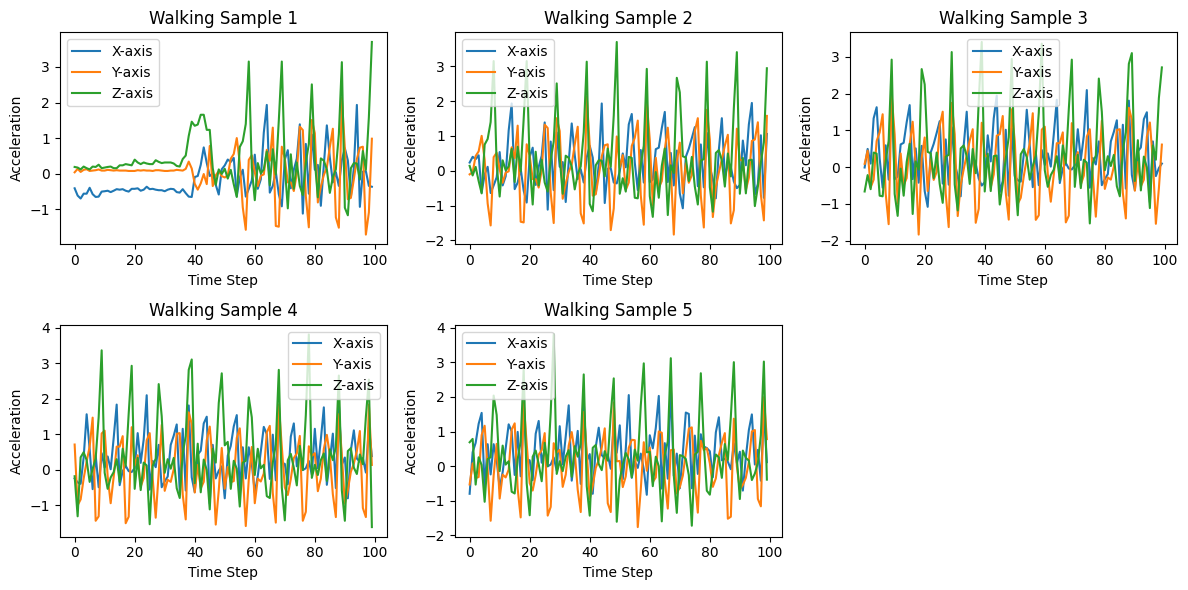

In [22]:
# Plot activity curves for each activity
for i, activity in enumerate(label_encoder.classes_):
    print(f"\nActivity curves for: {activity}")
    plot_activity_curves(trained_model, X_test, y_test, activity_index=i)

In [23]:
## Activity Detection Demonstration
def detect_activity(model, sample_data):
    model.eval()
    model = model.to(device)
    sample_tensor = torch.FloatTensor(sample_data).unsqueeze(0).to(device)  # Add batch dimension
    
    with torch.no_grad():
        outputs = model(sample_tensor)
        probs = torch.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probs, 1)
    
    class_probs = {label_encoder.classes_[i]: float(probs[0][i]) 
                   for i in range(len(label_encoder.classes_))}
    
    return {
        'predicted_activity': label_encoder.classes_[predicted.item()],
        'confidence': float(confidence.item()),
        'class_probabilities': class_probs
    }

In [24]:
# Example usage of activity detection
print("\nActivity Detection Demonstration:")
sample_idx = np.random.choice(len(X_test))
sample_data = X_test[sample_idx]
true_activity = label_encoder.classes_[y_test[sample_idx]]

# Detect activity
result = detect_activity(trained_model, sample_data)

print(f"\nSample {sample_idx}:")
print(f"True Activity: {true_activity}")
print(f"Predicted Activity: {result['predicted_activity']}")
print(f"Confidence: {result['confidence']:.2%}")
print("\nClass Probabilities:")
for activity, prob in result['class_probabilities'].items():
    print(f"{activity}: {prob:.2%}")


Activity Detection Demonstration:

Sample 4282:
True Activity: Walking
Predicted Activity: Walking
Confidence: 100.00%

Class Probabilities:
Downstairs: 0.00%
Jogging: 0.00%
Sitting: 0.00%
Standing: 0.00%
Upstairs: 0.00%
Walking: 100.00%


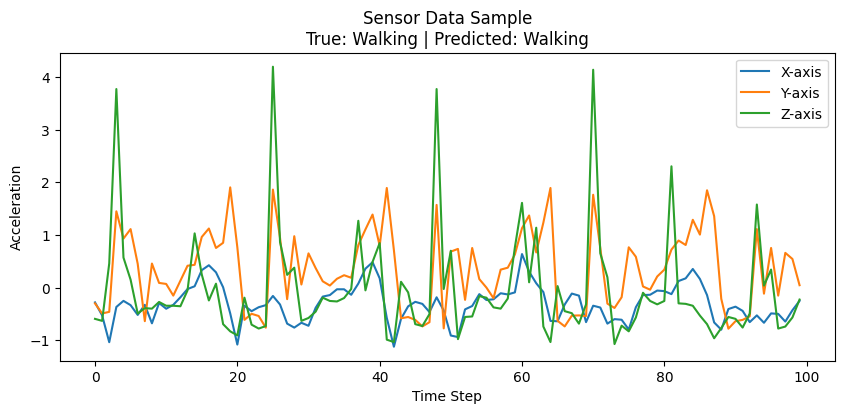

In [25]:
# Plot the sample data
plt.figure(figsize=(10, 4))
plt.plot(sample_data[:, 0], label='X-axis')
plt.plot(sample_data[:, 1], label='Y-axis')
plt.plot(sample_data[:, 2], label='Z-axis')
plt.title(f'Sensor Data Sample\nTrue: {true_activity} | Predicted: {result["predicted_activity"]}')
plt.xlabel('Time Step')
plt.ylabel('Acceleration')
plt.legend()
plt.show()

In [26]:
## Save Model
def save_model(model, label_encoder, file_path='fd_kan_activity_model.pth'):
    torch.save({
        'model_state_dict': model.state_dict(),
        'label_encoder': label_encoder
    }, file_path)
    print(f"Model saved to {file_path}")

save_model(trained_model, label_encoder)

Model saved to fd_kan_activity_model.pth


In [27]:
## Final Evaluation
def print_final_metrics(model, X_test, y_test):
    test_loss, test_acc, test_preds, test_labels, test_probs = evaluate(model, X_test, y_test)
    
    print("\nFinal Test Metrics:")
    print(f"Accuracy: {test_acc:.2f}%")
    print(f"Loss: {test_loss:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(
        test_labels, test_preds, 
        target_names=label_encoder.classes_
    ))

    cm = confusion_matrix(test_labels, test_preds)
    class_acc = cm.diagonal() / cm.sum(axis=1)
    
    print("\nPer-Class Accuracy:")
    for cls, acc in zip(label_encoder.classes_, class_acc):
        print(f"{cls}: {acc:.2%}")

print_final_metrics(trained_model, X_test, y_test)


Final Test Metrics:
Accuracy: 90.35%
Loss: 0.7238

Classification Report:
              precision    recall  f1-score   support

  Downstairs       0.83      0.84      0.83       555
     Jogging       0.98      0.92      0.95      1689
     Sitting       0.97      0.81      0.88       211
    Standing       0.80      0.97      0.88       183
    Upstairs       0.84      0.81      0.82       810
     Walking       0.90      0.95      0.92      1818

    accuracy                           0.90      5266
   macro avg       0.88      0.88      0.88      5266
weighted avg       0.91      0.90      0.90      5266


Per-Class Accuracy:
Downstairs: 83.60%
Jogging: 92.18%
Sitting: 81.04%
Standing: 97.27%
Upstairs: 80.62%
Walking: 95.43%
